<u>Reload modules</u>

In [1]:
%load_ext autoreload
%autoreload 2

<u>Imports</u>

In [2]:
# imports

import os
from os import listdir
from os.path import isfile, split, join

# Calculus

import numpy as np
import pandas as pd

# Audio processing

from midi2audio import FluidSynth
import pretty_midi
import librosa
import mido
from mido import MidiFile, MidiTrack, Message, MetaMessage

# Image processing

from PIL import Image

# Display

import matplotlib.pyplot as plt

# Model

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Dropout
import keras

2024-03-11 12:24:26.566815: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<u>Paths</u>

In [3]:
midi_path = "./data/midis/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I.mid"
midi_path2 = "./data/midis/Beach, Amy Marcy, 2 Piano Pieces, Op.102, kTBbDsx5l64.mid"
chunk_directory = "./data/chunks"
wav_directory = "./data/wav"
spect_directory = "./data/spect"



<u>Useful functions</u>

function 1: <b>create chunks</b>

<FONT COLOR="#ff0000"><b>!!! Code from github project !!!</b></FONT>

In [4]:
def split_midi_into_chunks(mid_file, target_directory, default_tempo=500000, target_segment_len=1):

# Split the "mid_file" into many chunks and store them in the "target_dir"

  song_name = split(mid_file)[-1][:-4]
  mid = MidiFile(mid_file)

# identify the meta messages

  metas = []
  tempo = default_tempo
  for msg in mid:
    if msg.type == 'set_tempo':
      tempo = msg.tempo
    if msg.is_meta:
      metas.append(msg)
  for meta in metas:
    meta.time = int(mido.second2tick(meta.time, mid.ticks_per_beat, tempo))

  target = MidiFile()
  track = MidiTrack()
  track.extend(metas)
  target.tracks.append(track)
  prefix = 0
  time_elapsed = 0
  for msg in mid:
    # Skip non-note related messages
    if msg.is_meta:
      continue
    time_elapsed += msg.time
    if msg.type != 'end_of_track':
      msg.time = int(mido.second2tick(msg.time, mid.ticks_per_beat, tempo))
      track.append(msg)
    if msg.type == 'end_of_track' or time_elapsed >= target_segment_len:
      track.append(MetaMessage('end_of_track'))
      target.save(join(target_directory, song_name + '_{}.mid'.format(prefix)))
      target = MidiFile()
      track = MidiTrack()
      track.extend(metas)
      target.tracks.append(track)
      time_elapsed = 0
      prefix += 1

function 2: <b>convert midi to audio .wav and save them </b>

In [5]:
def convert_midi_to_wav(input_path=chunk_directory,output_path=wav_directory,soundfont="./soundfont/FluidR3_GM.sf2",data_size=100):

    # Converts the midi files in "input_path" into .wav audio files and store them in "output_path"

    wav_name_list = []
    
    files = list(os.scandir(input_path))

    indexing = 1
    
    for file in files[0:data_size]:
        fs = FluidSynth(soundfont)
        input = os.path.join(input_path, file.name)
        output = os.path.join(output_path, f"{file.name}.wav")
        fs.midi_to_audio(input,output)
        wav_name_list.append(f"{file.name}")
        print(f".wav #{indexing} saved!")
        indexing = indexing + 1

    return wav_name_list

function 3: <b>convert .wav into spectograms and save them </b>(X preprocessing step)

In [6]:
def from_audio_to_spectograms(input_path=wav_directory,output_path=spect_directory):
    
    indexing_value = 0
    spect_name_list = []
    files = [file for file in os.scandir(wav_directory) if file.name[-4:]==".wav"]

    for file in files :
        plt.figure(figsize=(7.5, 3.75))
        y, sr = librosa.load(file, sr=None)
        C = librosa.cqt(y, sr=sr)
        #fig, ax = plt.subplots()
        librosa.display.specshow(librosa.amplitude_to_db(np.abs(C), ref=np.max),sr=sr)
        plt.axis('off')
        output_name = f'spectrogram{indexing_value}.png'
        plt.savefig(os.path.join(output_path, output_name),bbox_inches="tight")
        plt.close('all')
        spect_name_list.append(output_name[:-4])
        (f"{output_name} saved!")
        indexing_value = indexing_value + 1
    
    return spect_name_list

In [7]:
def plot_cqt(song, path):
  plt.figure(figsize=(7.5, 3.75))
  y, sr = librosa.load(song)
  C = librosa.cqt(y, sr=sr)
  librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                            sr=sr)
  plt.axis('off')
  plt.savefig(path, bbox_inches="tight")
  #plt.close('all')

function 4: <b>returns clean & normalized X_normalized from a list of spectogram image </b>(X)

In [8]:
def from_img_to_array (input_path=spect_directory,img_size=(49,154)):
    
    array_img_list = []

    name_list = [file.name for file in os.scandir(input_path) if file.name[-4:]==".png"]
    
    for name in name_list :
        
        # Removes the white frame and resizes the image
        step1 = Image.open(os.path.join(input_path, name)).crop((10,9,506,379)).resize(img_size, Image.NEAREST)
        
        # Converts the image into np.array (RGBA)
        step2 = np.array(step1)

        # Normalizes the data 
        step3 = step2 / 255

        # removes the last dimension which is useless
        step4 = step3[:, :, :3] 

        array_img_list.append(step4)

    X_normalized = np.array(array_img_list).reshape(len(array_img_list),img_size[0],img_size[1],3)
    
    return X_normalized

In [9]:
def plot_cqt(song, path):
    plt.figure(figsize=(7.5, 3.75))
    y, sr = librosa.load(song)
    C = librosa.cqt(y, sr=sr)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(C), ref=np.max),sr=sr)
    plt.axis('off')
    plt.savefig(path, bbox_inches="tight")
    #plt.close('all')

Step 5: <b>encoding midi files notes </b>(preparation for y)

<FONT COLOR="#ff0000"><b>!!! Code from github project !!!</b></FONT>

In [10]:
#def pretty_midi_to_one_hot(pretty_midi_file, fs=100):
#    one_hot = np.zeros((128, int(fs*pretty_midi_file.get_end_time())+1))
#    for note in pretty_midi_file.instruments[0].notes:
#        one_hot[note.pitch, int(note.start*fs)] = 1
#        #print('note on',note.pitch, int(note.start*fs))
#        one_hot[note.pitch, int(note.end*fs)] = 0
#        #print('note off',note.pitch, int(note.end*fs))
#    return one_hot

def pretty_midi_to_one_hot(pm, fs=100):
    """Compute a one hot matrix of a pretty midi object
    Parameters
    ----------
    pm : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    Returns
    -------
    one_hot : np.ndarray, shape=(128,times.shape[0])
        Piano roll of this instrument. 1 represents Note Ons,
        -1 represents Note offs, 0 represents constant/do-nothing
    """

    # Allocate a matrix of zeros - we will add in as we go
    one_hots = []

    if len(pm.instruments) < 1:
        return 0

    for instrument in pm.instruments:
        one_hot = np.zeros((128, int(fs*instrument.get_end_time())+1))
        for note in instrument.notes:
            # note on
            one_hot[note.pitch, int(note.start*fs)] = 1
            # print('note on',note.pitch, int(note.start*fs))
            # note off
            one_hot[note.pitch, int(note.end*fs)] = 0
            # print('note off',note.pitch, int(note.end*fs))
        one_hots.append(one_hot)

    one_hot = np.zeros((128, np.max([o.shape[1] for o in one_hots])))
    for o in one_hots:
        one_hot[:, :o.shape[1]] += o

    one_hot = np.clip(one_hot,-1,1)
    return one_hot

def slice_to_categories(piano_roll):
    notes_list = np.zeros(128)
    notes = np.nonzero(piano_roll)[0]
    notes = np.unique(notes)

    for note in notes:
        notes_list[note] = 1

    return notes_list

Step 6: <b>turns midi chunks into arrays </b>(y "one hot" encoded)

In [11]:
def midi_to_oh_arrays (wav_name_list, input_path = chunk_directory) :
    
    y_list = []
    
    chunk_to_encode = wav_name_list
    
    for chunk in chunk_to_encode :
        step0 = pretty_midi.PrettyMIDI(os.path.join(chunk_directory, chunk))
        step1 = pretty_midi_to_one_hot(step0)
        step2 = slice_to_categories(step1)
        y_list.append(step2)

    y_encoded = np.array(y_list)
    
    return y_encoded

<u>Create X and y</u>

In [12]:
data_size = 100

In [13]:
split_midi_into_chunks(midi_path,chunk_directory)

In [14]:
#split_midi_into_chunks(midi_path2,chunk_directory)

In [15]:
wav_name_list=convert_midi_to_wav(data_size=data_size)

fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_23.mid.wav'..
.wav #1 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_37.mid.wav'..
.wav #2 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_36.mid.wav'..
.wav #3 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_22.mid.wav'..
.wav #4 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_119.mid.wav'..
.wav #5 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_34.mid.wav'..
.wav #6 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_20.mid.wav'..
.wav #7 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_21.mid.wav'..
.wav #8 saved!
FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_35.mid.wav'..
.wav #9 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_118.mid.wav'..
.wav #10 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_120.mid.wav'..
.wav #11 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_108.mid.wav'..
.wav #12 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_31.mid.wav'..
.wav #13 saved!


fluidsynth: error: fluid_is_soundfont(): expected RIFF chunk id '0x46464952' but got '0x1000000'.
Parameter './data/chunks/.DS_Store' not a SoundFont or MIDI file or error occurred identifying it.
No midi file specified!


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

.wav #14 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_25.mid.wav'..
.wav #15 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_19.mid.wav'..
.wav #16 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_18.mid.wav'..
.wav #17 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_24.mid.wav'..
.wav #18 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_30.mid.wav'..
.wav #19 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_109.mid.wav'..
.wav #20 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_121.mid.wav'..
.wav #21 saved!
FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_123.mid.wav'..
.wav #22 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_26.mid.wav'..
.wav #23 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_32.mid.wav'..
.wav #24 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_33.mid.wav'..
.wav #25 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_27.mid.wav'..
.wav #26 saved!
FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_122.mid.wav'..
.wav #27 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_68.mid.wav'..
.wav #28 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_40.mid.wav'..
.wav #29 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_54.mid.wav'..
.wav #30 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_83.mid.wav'..
.wav #31 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_97.mid.wav'..
.wav #32 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_96.mid.wav'..
.wav #33 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_82.mid.wav'..
.wav #34 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_55.mid.wav'..
.wav #35 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_41.mid.wav'..
.wav #36 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_69.mid.wav'..
.wav #37 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_57.mid.wav'..
.wav #38 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_43.mid.wav'..
.wav #39 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_94.mid.wav'..
.wav #40 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_80.mid.wav'..
.wav #41 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_81.mid.wav'..
.wav #42 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_95.mid.wav'..
.wav #43 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_42.mid.wav'..
.wav #44 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_56.mid.wav'..
.wav #45 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_52.mid.wav'..
.wav #46 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_46.mid.wav'..
.wav #47 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_91.mid.wav'..
.wav #48 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_85.mid.wav'..
.wav #49 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_84.mid.wav'..
.wav #50 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_90.mid.wav'..
.wav #51 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_47.mid.wav'..
.wav #52 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_53.mid.wav'..
.wav #53 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_8.mid.wav'..
.wav #54 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_45.mid.wav'..
.wav #55 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_51.mid.wav'..
.wav #56 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_79.mid.wav'..
.wav #57 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_86.mid.wav'..
.wav #58 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_92.mid.wav'..
.wav #59 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_93.mid.wav'..
.wav #60 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_87.mid.wav'..
.wav #61 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_78.mid.wav'..
.wav #62 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_50.mid.wav'..
.wav #63 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_44.mid.wav'..
.wav #64 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_9.mid.wav'..
.wav #65 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_4.mid.wav'..
.wav #66 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_49.mid.wav'..
.wav #67 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_61.mid.wav'..
.wav #68 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_75.mid.wav'..
.wav #69 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_74.mid.wav'..
.wav #70 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_60.mid.wav'..
.wav #71 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_48.mid.wav'..
.wav #72 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_5.mid.wav'..
.wav #73 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_7.mid.wav'..
.wav #74 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_76.mid.wav'..
.wav #75 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_62.mid.wav'..
.wav #76 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_89.mid.wav'..
.wav #77 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_88.mid.wav'..
.wav #78 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_63.mid.wav'..
.wav #79 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_77.mid.wav'..
.wav #80 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_6.mid.wav'..
.wav #81 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_2.mid.wav'..
.wav #82 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_73.mid.wav'..
.wav #83 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_67.mid.wav'..
.wav #84 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_98.mid.wav'..
.wav #85 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_99.mid.wav'..
.wav #86 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_66.mid.wav'..
.wav #87 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_72.mid.wav'..
.wav #88 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_3.mid.wav'..
.wav #89 saved!
FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_1.mid.wav'..
.wav #90 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_64.mid.wav'..
.wav #91 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_70.mid.wav'..
.wav #92 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_58.mid.wav'..
.wav #93 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_59.mid.wav'..
.wav #94 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_71.mid.wav'..
.wav #95 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_65.mid.wav'..
.wav #96 saved!
FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_0.mid.wav'..
.wav #97 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_113.mid.wav'..
.wav #98 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_107.mid.wav'..
.wav #99 saved!
FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file './data/wav/Adams, Ernest Harry, Evening Invocation, vsq8voyBe0I_16.mid.wav'..
.wav #100 saved!


fluidsynth: warning: End of the MIDI file reached, but not all notes have received a note off event! OFFing them now! Run with --verbose to spot pending voices.


In [16]:
spect_name_list = from_audio_to_spectograms()

In [17]:
img_size=(49*3,145*3)

In [18]:
X_normalized = from_img_to_array(img_size=img_size)
X_normalized.shape

(99, 147, 435, 3)

In [19]:
wav_name_list2 = [name for name in wav_name_list if name[-4:]==".mid"]

In [20]:
y_encoded = midi_to_oh_arrays(wav_name_list2)
y_encoded.shape

(99, 128)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_encoded, test_size=0.2, random_state=42)

<u>Model creation and training</u>

In [22]:
epochs = 100
batch_size = 64
learning_rate = .000001

In [23]:
# Previous model

#model = Sequential()
#model.add(Conv2D(64, kernel_size=(5,5), strides=(1,1),activation='tanh',input_shape=(img_size[0], img_size[1], 3)))
#model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
#model.add(Conv2D(32, (3,3), activation='tanh'))
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Flatten())
#model.add(Dense(128, activation='softmax'))

# New model

model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5), strides=(1,1),activation='tanh',input_shape=(img_size[0], img_size[1], 3)))
#model.add(Dropout(0.5))@
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(64, (3,3), activation='tanh'))
#model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='sigmoid'))

In [29]:
import tensorflow as tf

In [31]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,decay_steps=10000,decay_rate=0.96,staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [32]:
#model.compile(loss=keras.losses.binary_crossentropy,optimizer=keras.optimizers.Adam(learning_rate=learning_rate),metrics=['accuracy'])
model.compile(loss=keras.losses.binary_crossentropy,optimizer=optimizer,metrics=['accuracy'])

In [33]:
model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,verbose=1)

Epoch 1/100
2/2 [==============================] - 18s 2s/step - loss: 0.4906 - accuracy: 0.0127
Epoch 2/100
2/2 [==============================] - 9s 2s/step - loss: 0.5204 - accuracy: 0.0633
Epoch 3/100
2/2 [==============================] - 6s 1s/step - loss: 0.3150 - accuracy: 0.0886
Epoch 4/100
2/2 [==============================] - 7s 2s/step - loss: 0.1669 - accuracy: 0.0253
Epoch 5/100
2/2 [==============================] - 7s 1s/step - loss: 0.1469 - accuracy: 0.0633
Epoch 6/100
2/2 [==============================] - 7s 1s/step - loss: 0.1011 - accuracy: 0.1266
Epoch 7/100
2/2 [==============================] - 7s 1s/step - loss: 0.0988 - accuracy: 0.1013
Epoch 8/100
2/2 [==============================] - 7s 1s/step - loss: 0.0858 - accuracy: 0.1772
Epoch 9/100
2/2 [==============================] - 6s 1s/step - loss: 0.0754 - accuracy: 0.1266
Epoch 10/100
2/2 [==============================] - 7s 1s/step - loss: 0.0621 - accuracy: 0.2152
Epoch 11/100
2/2 [====================

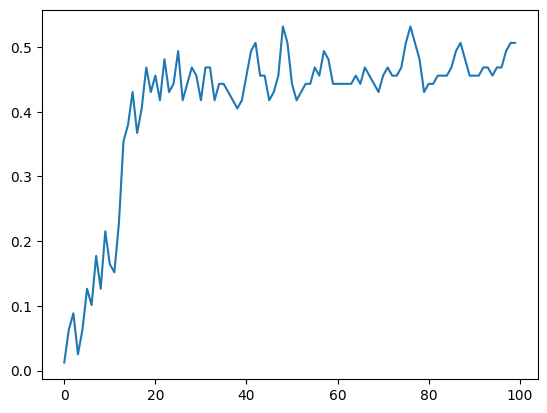

In [34]:
plt.plot(model.history.history["accuracy"])

<u>Prediction</u>

In [ ]:
y_predict = (model.predict(X_test) > 0.5).astype(int)

In [ ]:
y_predict[0]

In [ ]:
y_test[0]

In [ ]:
y_predict[1]

In [ ]:
y_test[1]

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_predict,y_test)

In [ ]:
notes, frames = y_predict.shape

In [ ]:
stop

In [ ]:
prettymidi = pretty_midi.PrettyMIDI()

In [ ]:
instrument = pretty_midi.Instrument(program=1) #Bright Acoustic Piano

In [ ]:
piano_roll = np.hstack((np.zeros((notes, 1)),y_predict,np.zeros((notes, 1))))

In [ ]:
piano_roll.shape

In [ ]:
changes = np.nonzero(np.diff(piano_roll).T)

In [ ]:
np.diff(piano_roll).T

In [ ]:
note_on_time = np.zeros(notes)
note_on_time

In [ ]:
current_notes = np.zeros(notes)
current_notes

In [ ]:
bps = 120 / 60
beat_interval = 100 / bps
strong_beats = beat_interval * 2
strong_beats

In [ ]:
times = []
notes = []
for time, note in zip(*changes):
    times.append(time)
    notes.append(note)

note = notes[0]
time = times[0]

In [ ]:
for note in notes : 
    print(current_notes[note])

In [ ]:
def one_hot_to_pretty_midi(one_hot, fs=100, program=1,bpm=120):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,time)
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    bpm : int
        Beats per minute, used to decide when to re-emphasize notes left on.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = one_hot.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # prepend, append zeros so we can acknowledge inital and ending events
    piano_roll = np.hstack((np.zeros((notes, 1)),
                            one_hot,
                            np.zeros((notes, 1))))

    # use changes to find note on / note off events
    changes = np.nonzero(np.diff(piano_roll).T)

    # keep track of note on times and notes currently playing
    note_on_time = np.zeros(notes)
    current_notes = np.zeros(notes)

    bps = bpm / 60
    beat_interval = fs / bps
    strong_beats = beat_interval * 2 #(for 4/4 timing)

    last_beat_time = 0

    for time, note in zip(*changes):
        change = piano_roll[note, time + 1]

        if time >= last_beat_time + beat_interval:
            for note in current_notes:
                time = time / fs

        time = time / fs
        if change == 1:
            # note on
            if current_notes[note] == 0:
                # from note off
                note_on_time[note] = time
                current_notes[note] = 1
            else:
                #re-articulate (later in code)
                '''pm_note = pretty_midi.Note(
                        velocity=100, #don't care fer now
                        pitch=note,
                        start=note_on_time[note],
                        end=time)
                instrument.notes.append(pm_note)
                note_on_time[note] = time
                current_notes[note] = 1'''
        elif change == 0:
            #print(note)
            #print(note_on_time.shape)
            #print(note_on_time[0])
            #note off
            pm_note = pretty_midi.Note(
                    velocity=100, #don't care fer now
                    pitch=note,
                    start=note_on_time[note],
                    end=time)
            current_notes[int(note)] = 0
            instrument.notes.append(pm_note)
    pm.instruments.append(instrument)
    return pm

In [ ]:
one_hot_to_pretty_midi(y_train)

In [ ]:
current_notes = np.zeros(128)
current_notes

In [ ]:
current_notes[120]=

In [ ]:
note_pitch_played = [k for k in y_pred if k !=0]
time_period = y_pred.shape[1]

# Créer un objet PrettyMIDI
midi_data = pretty_midi.PrettyMIDI()

# Ajouter un instrument (piano)
instrument = pretty_midi.Instrument(program=1)  # Selects the piano

# Ajouter quelques notes
# Exemple de note : pitch=60 (C4), start_time=0.0, end_time=1.0, velocity=100
note = pm.Note(velocity=100, pitch=60, start=0.0, end=1.0)
instrument.notes.append(note)

# Ajouter l'instrument à l'objet MIDI
midi_data.instruments.append(instrument)

# Écrire les données MIDI dans un fichier
midi_data.write('output.mid')